<h1>0. 功能依赖</h1>

In [2]:
import numpy as np
from numpy import polyfit, poly1d

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from collections import Counter

import seaborn as sns

import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, log_loss, auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import  StratifiedKFold,KFold,GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F


import xgboost as xgb
import lightgbm as lgb

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy import interp
from scipy.interpolate import make_interp_spline

color_set=['#ff7500','#db5a6b', '#ffb61e', '#4c8dae']

<h1>1. 数据导入与展示</h1>

<h2>1.1. 数据读入</h2>

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


<h2>1.2. 数据概览</h2>

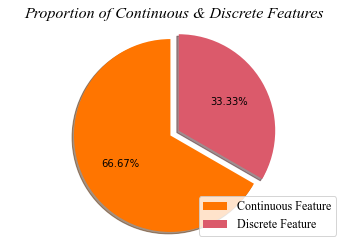

In [5]:
ct_feat = {}
dc_feat = {}
for col in list(train.drop('Status',axis=1).columns):
    if train[col].dtype == object:
        dc_feat[col]=list(train[col].values)
    else:
        ct_feat[col]=list(train[col].values)
id = ct_feat.pop('id')

ct_feat_num = len(ct_feat.keys())
dc_feat_num = len(dc_feat.keys())
all_feat = (ct_feat_num+dc_feat_num)/100
plt.figure()
plt.pie(
    x=[ct_feat_num/all_feat,dc_feat_num/all_feat],
    explode=[0.1,0],
    labels=['Continuous Feature', 'Discrete Feature'],
    colors=['#ff7500','#db5a6b'],
    autopct='%1.2f%%',
    shadow=True,
    startangle=90,
    labeldistance=None,
)
plt.axis('equal')
plt.title('Proportion of Continuous & Discrete Features', 
          fontdict=dict(fontsize=16,
                        color='black',
                        family='Times New Roman',
                        weight='light',
                        style='italic',))
plt.legend(loc='lower right',
           prop= {'family' : 'Times New Roman',
                  'weight' : 'normal',
                  'size'   : 12,})
plt.show()

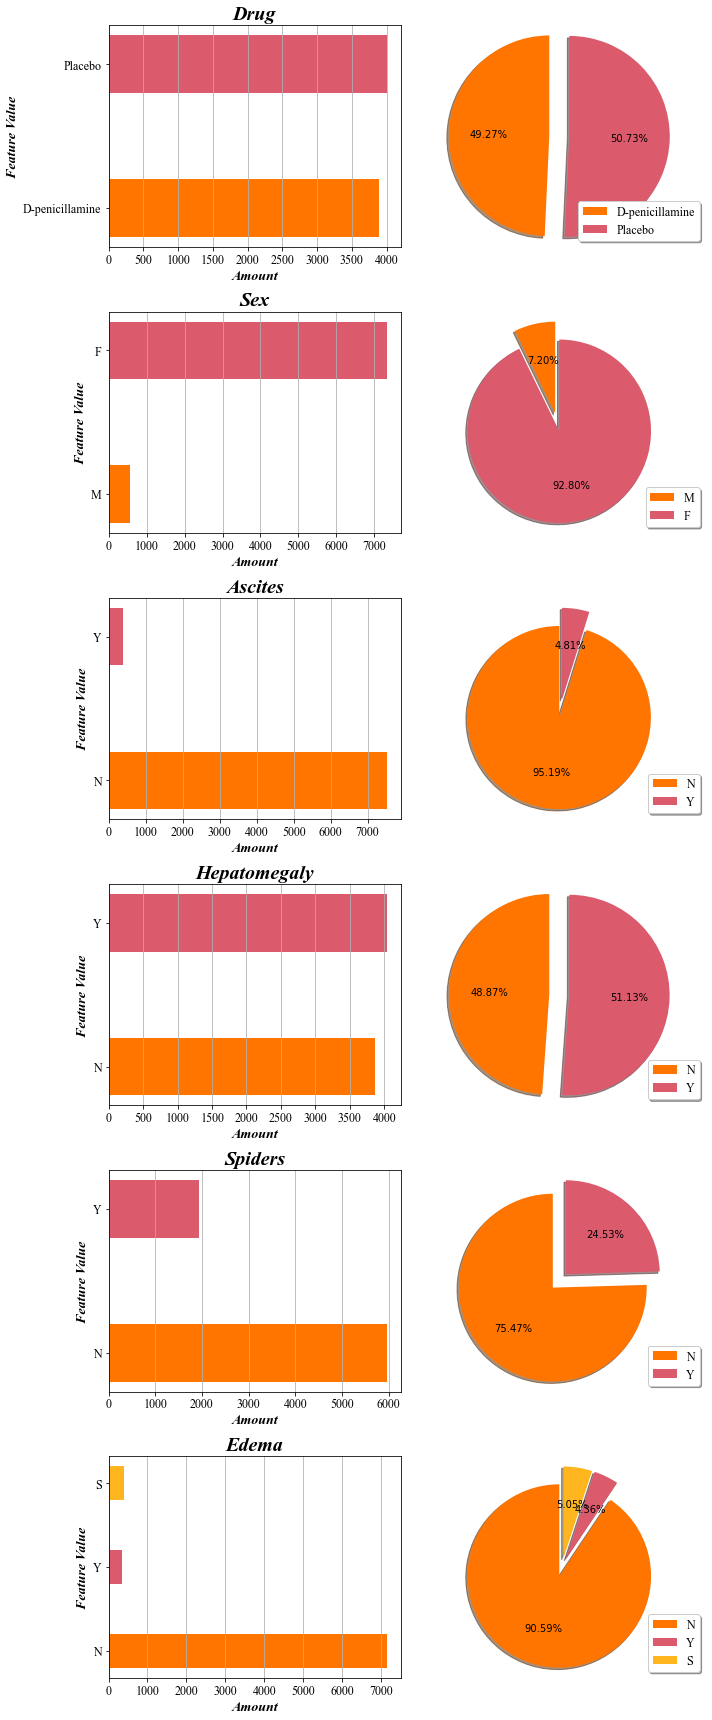

In [6]:
plt.figure(figsize=(10,len(list(dc_feat.keys()))*4))
for i in range(0, dc_feat_num):
    
    plt.subplot(dc_feat_num, 2, 2*(i+1)-1)
    plt.title('{}'.format(list(dc_feat.keys())[i]),
              fontdict=dict(fontsize=20,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
    count = Counter(dc_feat[list(dc_feat.keys())[i]])
    #cmap = matplotlib.colormaps["rainbow"]
    #colors = cmap(np.linspace(0, 1, len(count.keys())))
    colors = [color_set[j] for j in range(0,len(list(count.keys())))]
    plt.grid(linestyle='-',
             axis='x',
             zorder=0)
    bar = plt.barh(list(count.keys()),
                   list(count.values()),
                   color=colors,
                   label=list(count.keys()),
                   height=0.4,
                   zorder=1
                   )
    plt.ylabel('Feature Value',
               fontdict=dict(fontsize=14,
                             color='black',
                             family='Times New Roman',
                             weight='bold',
                             style='italic',))
    plt.xlabel('Amount',
               fontdict=dict(fontsize=14,
                             color='black',
                             family='Times New Roman',
                             weight='bold',
                             style='italic',))
    plt.xticks(fontproperties='Times New Roman', size = 12)
    plt.yticks(fontproperties='Times New Roman', size = 12)

    plt.subplot(dc_feat_num, 2, 2*(i+1))
    sample_amount = train.shape[0]
    plt.pie(
        x= [j/sample_amount*100 for j in list(count.values())],
        explode=[0.1]+[0.1 for j in range(0,len(list(count.keys()))-1)],
        labels=list(count.keys()),
        colors=colors,
        autopct='%1.2f%%',
        shadow=True,
        startangle=90,
        labeldistance=None,
    )
    plt.legend(loc='lower right',
               prop= {'family' : 'Times New Roman',
                      'weight' : 'normal',
                      'size'   : 12,},
                shadow=True)
    plt.axis('equal')
    
plt.tight_layout() 
plt.show()

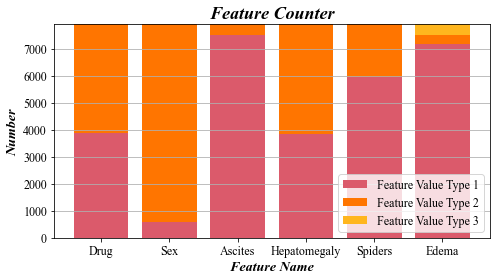

In [7]:
group1 = []
group2 = []
group3 = []
for feature in list(dc_feat.keys()):
    count = Counter(dc_feat[feature])
    if len(list(count.keys())) == 2:
        group1.append(list(count.values())[0])
        group2.append(list(count.values())[1])
        group3.append(0)
    else:
        group1.append(list(count.values())[0])
        group2.append(list(count.values())[1])
        group3.append(list(count.values())[2])

fig, ax = plt.subplots(figsize=(7,4))
d=[]
for i in range(0,len(group1)):
    sum = group1[i] + group2[i]
    d.append(sum)
bar1 = ax.bar(list(dc_feat.keys()), group1, label='Feature Value Type 1', color=color_set[1])
bar2 = ax.bar(list(dc_feat.keys()), group2, bottom=group1, label='Feature Value Type 2', color=color_set[0])
bar3 = ax.bar(list(dc_feat.keys()), group3, bottom=d, label='Feature Value Type 3', color=color_set[2])
ax.legend(loc='lower right',
          prop= {'family' : 'Times New Roman',
                 'weight' : 'normal',
                 'size'   : 12,},
          shadow=False)
ax.set_title('Feature Counter',
             fontdict=dict(fontsize=18,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
ax.set_xlabel('Feature Name',
              fontdict=dict(fontsize=14,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
ax.set_ylabel('Number',
              fontdict=dict(fontsize=14,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
plt.grid(linestyle='-',
             axis='y',
             zorder=-1)
plt.xticks(fontproperties='Times New Roman', size = 12)
plt.yticks(fontproperties='Times New Roman', size = 12)
plt.tight_layout()
plt.show()

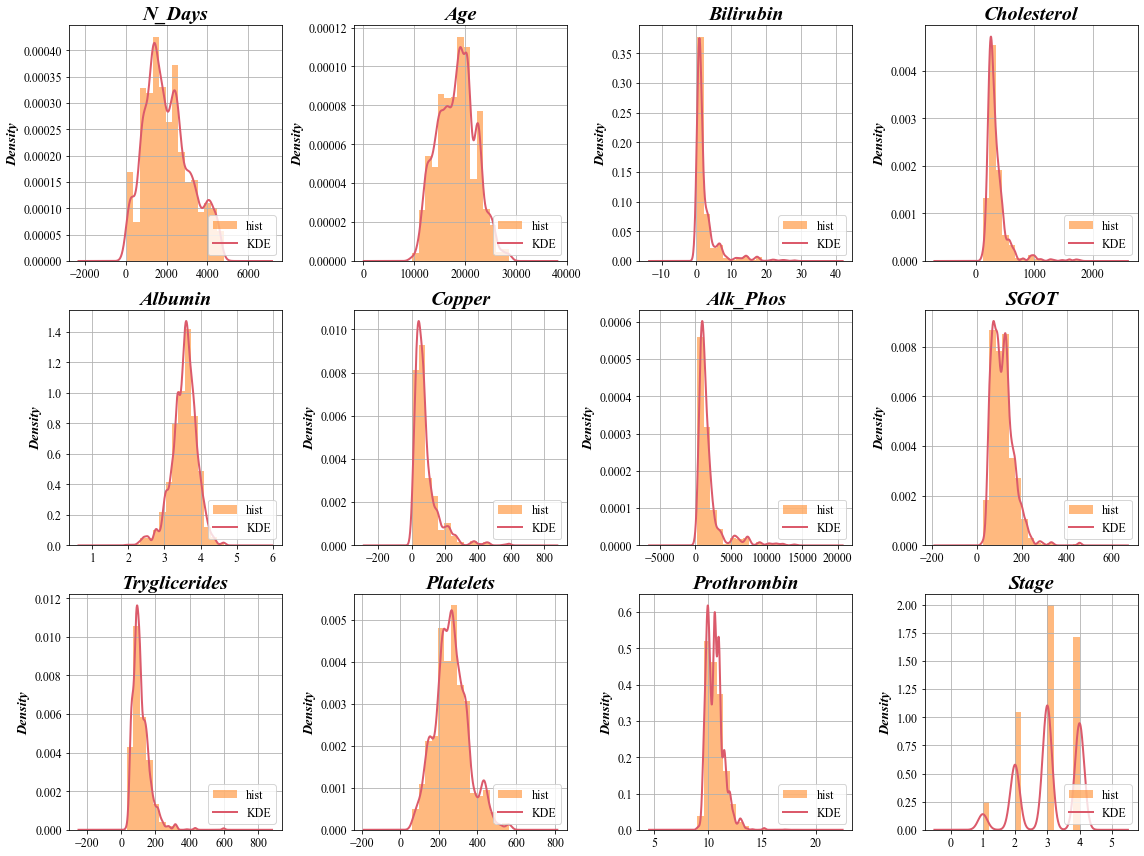

In [8]:
plt.figure(figsize=(16,12))
for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.title(list(ct_feat.keys())[i],
              fontdict=dict(fontsize=20,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
    train[list(ct_feat.keys())[i]].plot(kind = 'hist',
                                       bins = 15,
                                       color = color_set[0],
                                       density=True,
                                       alpha=0.5,
                                       label='hist')
    train[list(ct_feat.keys())[i]].plot(kind = 'kde',
                                       color = color_set[1],
                                       label='KDE',
                                       lw=2,)
    
    plt.grid(linestyle='-',
             axis='both',
             zorder=-1)
    plt.legend(loc='lower right',
               prop= {'family' : 'Times New Roman',
                 'weight' : 'normal',
                 'size'   : 12,},
               shadow=False)
    plt.ylabel('Density',
               fontdict=dict(fontsize=14,
                             color='black',
                             family='Times New Roman',
                             weight='bold',
                             style='italic',))
    plt.xticks(fontproperties='Times New Roman', size = 12)
    plt.yticks(fontproperties='Times New Roman', size = 12)
plt.tight_layout()
plt.show()

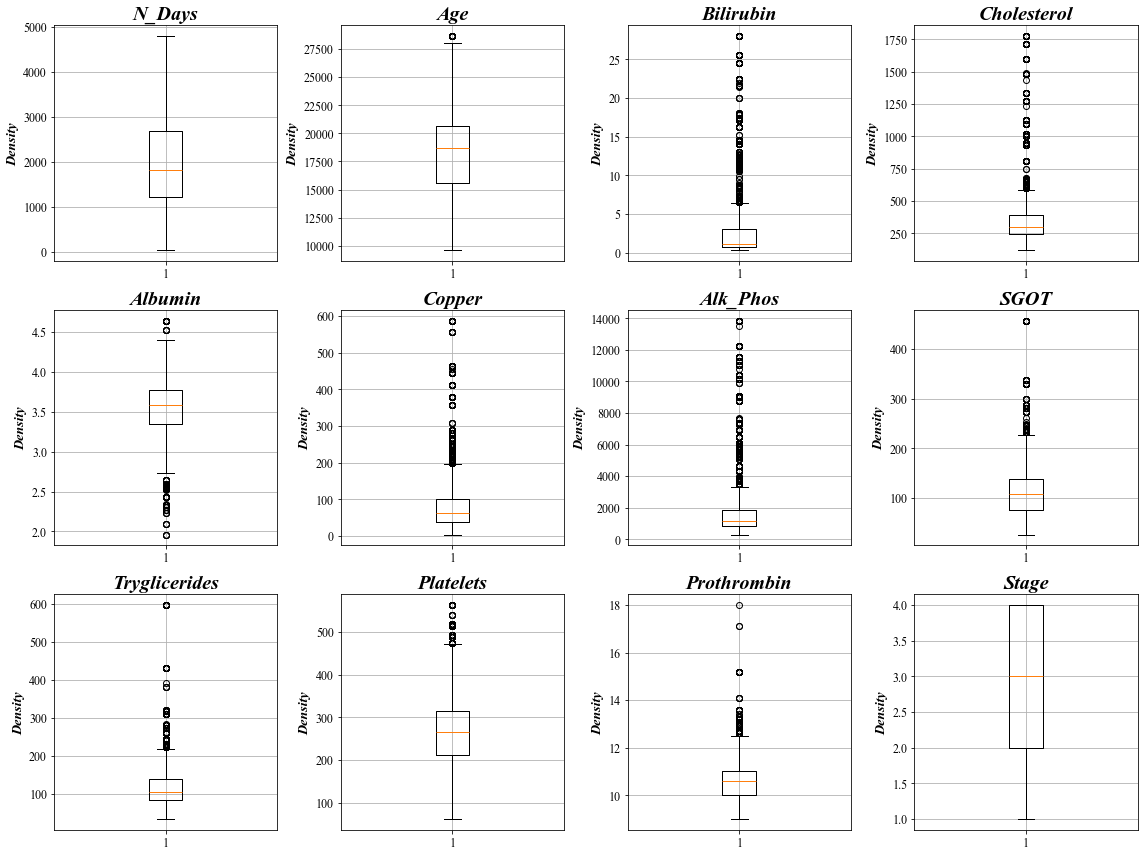

In [9]:
plt.figure(figsize=(16,12))
for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.title(list(ct_feat.keys())[i],
              fontdict=dict(fontsize=20,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
    plt.boxplot(train[list(ct_feat.keys())[i]])  
    plt.grid(linestyle='-',
             axis='both',
             zorder=-1)
  
    plt.ylabel('Density',
               fontdict=dict(fontsize=14,
                             color='black',
                             family='Times New Roman',
                             weight='bold',
                             style='italic',))
    plt.xticks(fontproperties='Times New Roman', size = 12)
    plt.yticks(fontproperties='Times New Roman', size = 12)
plt.tight_layout()
plt.show()

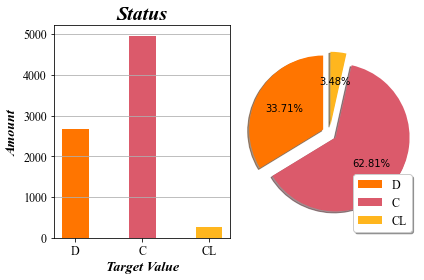

In [10]:
plt.figure()
plt.subplot(1,2,1)
plt.title('Status',
          fontdict=dict(fontsize=20,
                        color='black',
                        family='Times New Roman',
                        weight='bold',
                        style='italic',))
count = Counter(train['Status'].values)
colors = [color_set[j] for j in range(0,len(list(count.keys())))]
plt.grid(linestyle='-',
         axis='y',)
bar = plt.bar(list(count.keys()),
               list(count.values()),
               color=colors,
               label=list(count.keys()),
               width=0.4)
plt.xlabel('Target Value',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.ylabel('Amount',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.xticks(fontproperties='Times New Roman', size = 12)
plt.yticks(fontproperties='Times New Roman', size = 12)

plt.subplot(1,2,2)
sample_amount = train.shape[0]
plt.pie(
        x= [j/sample_amount*100 for j in list(count.values())],
        explode=[0.1]+[0.1 for j in range(0,len(list(count.keys()))-1)],
        labels=list(count.keys()),
        colors=colors,
        autopct='%1.2f%%',
        shadow=True,
        startangle=90,
        labeldistance=None,)
plt.legend(loc='lower right',
            prop= {'family' : 'Times New Roman',
                      'weight' : 'normal',
                      'size'   : 12,},
            shadow=True)
plt.axis('equal')
plt.tight_layout()
plt.show()

<h1>2. 数据预处理</h1>

<h2>2.1. 相关性分析</h2>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, 'N_Days'),
  Text(0, 1.5, 'Age'),
  Text(0, 2.5, 'Bilirubin'),
  Text(0, 3.5, 'Cholesterol'),
  Text(0, 4.5, 'Albumin'),
  Text(0, 5.5, 'Copper'),
  Text(0, 6.5, 'Alk_Phos'),
  Text(0, 7.5, 'SGOT'),
  Text(0, 8.5, 'Tryglicerides'),
  Text(0, 9.5, 'Platelets'),
  Text(0, 10.5, 'Prothrombin')])

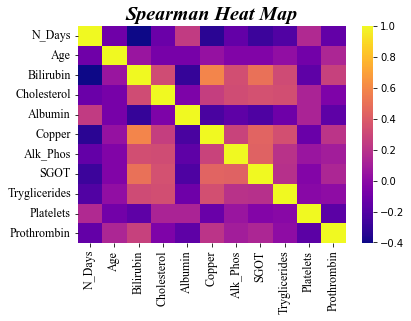

In [11]:
plt.figure()
sns.heatmap(train.drop(list(dc_feat.keys())+['Status','id','Stage'],axis=1).corr(method='spearman'),
                       cmap='plasma',)
plt.title('Spearman Heat Map',
          fontdict=dict(fontsize=20,
                        color='black',
                        family='Times New Roman',
                        weight='bold',
                        style='italic',))
plt.xticks(fontproperties='Times New Roman', size = 12)
plt.yticks(fontproperties='Times New Roman', size = 12)

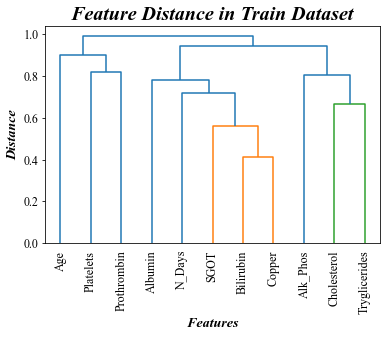

In [12]:

corr = train.drop(list(dc_feat.keys())+['Status','id','Stage'],axis=1).corr(method='spearman')
dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')
plt.figure()
dendro = dendrogram(dist_linkage,
                    labels=train.drop(list(dc_feat.keys())+['Status','id','Stage'],axis=1)._get_numeric_data().columns,
                    leaf_rotation=90,)
plt.title('Feature Distance in Train Dataset',
          fontdict=dict(fontsize=20,
                        color='black',
                        family='Times New Roman',
                        weight='bold',
                        style='italic',))
plt.xlabel('Features',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.ylabel('Distance',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.xticks(fontproperties='Times New Roman', size = 12)
plt.yticks(fontproperties='Times New Roman', size = 12)
plt.show()

<h2>2.2. 标准化与编码</h2>

In [4]:
y=train['Status'].values
le=LabelEncoder().fit(y)
y=le.transform(y)
X=train.drop(['Status'],axis=1)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), 
         [col_name for col_name in list(X) if X[col_name].dtype == 'object' or col_name == 'Stage']),
        ('num', StandardScaler(), 
         [col_name for col_name in list(X) if X[col_name].dtype == 'float64' and col_name != 'Stage']),
    ]
)
preprocessed_X = preprocessor.fit_transform(X)

<h1>3. 模型训练</h1>

<h2>3.1. 机器学习</h2>

In [5]:
seed=42
splits=10
skf=StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
np.random.seed(seed)

In [6]:
def cross_val_score(estimator,
                    cv = skf,
                    label = '',
                    include_original = False,
                    X=preprocessed_X, y=y):
    train_scores, val_scores = [], []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        model = clone(estimator)
        X_train = X[train_idx]
        y_train = y[train_idx] 
        X_val = X[val_idx]
        y_val = y[val_idx]

        model.fit(X_train, y_train)
        val_preds = model.predict_proba(X_val).clip(1e-15, 1 - 1e-15)
        val_score = log_loss(y_val, val_preds)
        val_scores.append(val_score)
    
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | {label}')
    
    return val_scores

In [7]:
score_list = pd.DataFrame()
models=[
    ('svc', SVC(random_state=seed,
                probability = True,
                kernel='sigmoid')),
    ('log', LogisticRegression(random_state = seed,
                               max_iter = 1000000,
                               class_weight='balanced')),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(random_state = seed,
                                  class_weight='balanced')),
    ('ada', AdaBoostClassifier(random_state = seed,
                               n_estimators=10)),
    ('xgb', xgb.XGBClassifier(random_state = seed,
                              num_class=3)),
    ('lgb', lgb.LGBMClassifier(random_state = seed,
                               learning_rate=0.5,
                               objective='multiclass',
                               boosting_type='gbdt',
                               num_class=3)),
    ('rf', lgb.LGBMClassifier(random_state = seed,
                              objective='multiclass',
                              boosting_type='rf',
                              num_class=3,
                              bagging_fraction=0.7,
                              bagging_freq=1)),
    ('dart', lgb.LGBMClassifier(random_state = seed,
                                boosting_type='dart',
                                num_class=3)),
    ('mlp', MLPClassifier(random_state = seed,
                          solver='lbfgs',
                          activation='relu',
                          alpha=0.1,
                          hidden_layer_sizes=[20,20],
                          max_iter=1000))
]

for (label, model) in models:
    score_list[label] = cross_val_score(model, 
                                        label=label,)

Val Score: 0.67015 ± 0.03034 | svc
Val Score: 0.81892 ± 0.02734 | log
Val Score: 0.54787 ± 0.01966 | lda
Val Score: 2.57898 ± 0.13747 | gnb
Val Score: 0.86899 ± 0.05341 | bnb
Val Score: 2.77089 ± 0.18664 | knn
Val Score: 9.73943 ± 0.48039 | dt
Val Score: 0.95141 ± 0.00215 | ada
Val Score: 0.52951 ± 0.02444 | xgb
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 26
[LightGBM] [Info] Start training from score -0.464900
[LightGBM] [Info] Start training from score -3.360432
[LightGBM] [Info] Start training from score -1.087430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

c:\Users\15835\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\15835\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\15835\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

Val Score: 0.72746 ± 0.04450 | mlp


c:\Users\15835\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [8]:
score_list

,svc,log,lda,gnb,bnb,knn,dt,ada,xgb,lgb,rf,dart,mlp
0,0.629346,0.832157,0.537820,2.554793,0.776200,2.796038,9.125922,0.951151,0.548533,0.806593,0.525887,0.482084,0.707955
1,0.688039,0.777964,0.517132,2.398000,0.815835,2.994117,10.480071,0.948322,0.543053,0.817284,0.517862,0.486455,0.676717
2,0.717353,0.863054,0.594349,2.771657,0.966034,2.944263,9.868222,0.954552,0.548745,0.846935,0.534378,0.497629,0.772804
3,0.705171,0.801562,0.546179,2.548778,0.881283,2.585346,9.431575,0.951045,0.545855,0.810305,0.513734,0.478140,0.662993
4,0.661946,0.781356,0.531369,2.482661,0.872246,2.608980,9.956094,0.948509,0.479028,0.717966,0.487757,0.450556,0.774613
5,0.658738,0.830391,0.556840,2.609079,0.894874,2.847737,10.232348,0.950933,0.520228,0.789860,0.526922,0.482203,0.751128
6,0.627402,0.847281,0.550888,2.601988,0.839730,2.393302,8.789045,0.950354,0.506097,0.771100,0.489953,0.464114,0.706097
7,0.702133,0.844197,0.562000,2.842223,0.941817,2.756221,9.880713,0.954816,0.564765,0.838409,0.547587,0.493322,0.759341
8,0.668026,0.809787,0.541144,2.594848,0.854977,3.012749,9.662113,0.953625,0.510401,0.780484,0.541492,0.486494,0.675108
9,0.643393,0.801474,0.540933,2.385733,0.846950,2.770109,9.968153,0.950790,0.528440,0.783160,0.518606,0.473599,0.787810


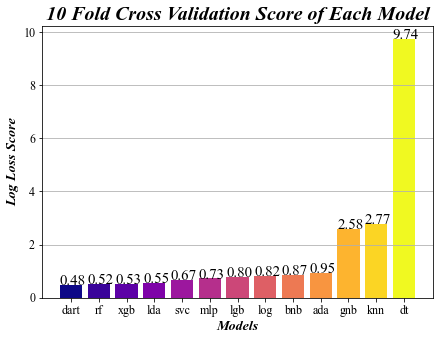

In [9]:
sorted_score = sorted([np.mean(score_list[i].values) for i in list(score_list)])
sorted_label = []
for i in range(0,len(list(score_list))):
    for col in score_list.columns:
        if np.mean(score_list[col].values) == sorted_score[i]:
            sorted_label.append(col)

def autolabel(rects,y):
    count=0
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x(), 1*height, '%.2f' % y[count], size=15, family="Times new roman")
        count+=1

plt.figure(figsize=(7,5))
cmap = mpl.colormaps["plasma"]
colors = cmap(np.linspace(0, 1, len(score_list.columns)))
bar = plt.bar(sorted_label,
              sorted_score,
              color=colors)
autolabel(bar,sorted_score)
plt.grid(linestyle='-',
         axis='y',)
plt.title('10 Fold Cross Validation Score of Each Model',
          fontdict=dict(fontsize=20,
                        color='black',
                        family='Times New Roman',
                        weight='bold',
                        style='italic',))
plt.xlabel('Models',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.ylabel('Log Loss Score',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.xticks(fontproperties='Times New Roman', size = 12)
plt.yticks(fontproperties='Times New Roman', size = 12)
plt.show()

In [10]:
def muticlass_roc_curve(model,label='',line_color='navy', class_num=3):
    model = clone(model)
    X_train,X_val,y_train,y_val = train_test_split(preprocessed_X,
                                                   y,
                                                   random_state=seed, 
                                                   shuffle=False)
    y_val_full =[]
    for i in y_val:
        temp =[0,0,0]
        temp[i]=1
        y_val_full.append(temp)


    model.fit(X_train,y_train)
    y_prob = model.predict_proba(X_val)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(class_num):
        fpr[i], tpr[i], _ = roc_curve(np.array(y_val_full)[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(class_num):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= class_num
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
            label='{0}(area = {1:0.2f})'.format(label,roc_auc["macro"]),
            color=line_color, linestyle='-', linewidth=2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 26
[LightGBM] [Info] Start training from score -0.465157
[LightGBM] [Info] Start training from score -3.354723
[LightGBM] [Info] Start training from score -1.087540
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 secon

c:\Users\15835\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

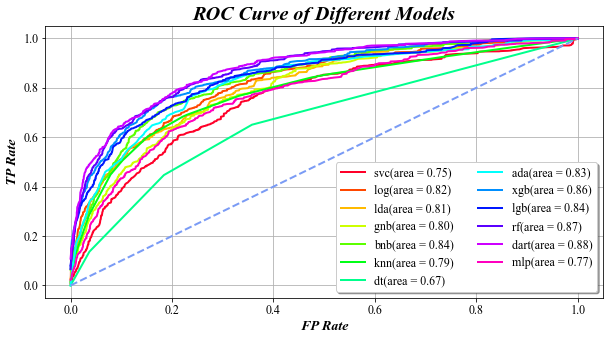

In [11]:
cmap = mpl.colormaps["gist_rainbow"]
roc_colors=cmap(np.linspace(0, 1, len(score_list.columns)))
color_count=0

plt.figure(figsize=(10,5))
for (label, model) in models:
    muticlass_roc_curve(model,label=label,line_color=roc_colors[color_count], class_num=3)
    color_count+=1
plt.plot([0,1],[0,1], color='#7A9BF5', lw=2, linestyle='--')
plt.grid(linestyle='-',
         axis='both',)
plt.legend(loc='lower right',
            prop= {'family' : 'Times New Roman',
                      'weight' : 'normal',
                      'size'   : 12,},
            shadow=True,
            ncol = 2,
            fancybox= True)
plt.title('ROC Curve of Different Models',
          fontdict=dict(fontsize=20,
                        color='black',
                        family='Times New Roman',
                        weight='bold',
                        style='italic',))
plt.xlabel('FP Rate',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.ylabel('TP Rate',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.xticks(fontproperties='Times New Roman', size = 12)
plt.yticks(fontproperties='Times New Roman', size = 12)



<h2>3.2. 参数调优</h2>

In [16]:
def compare_plot(compare_model):
    plt.figure(figsize=(10,5))
    
    color_count=0
    for (label,model) in compare_model:
        plt.subplot(1,2,1)
        muticlass_roc_curve(model,label=label,
                            line_color=['#c93756','#16a951'][color_count],
                            class_num=3)
        plt.legend(loc='lower right',
                   prop= {'family' : 'Times New Roman',
                          'weight' : 'normal',
                          'size'   : 12,},
                   shadow=True,
                   ncol = 1,
                   fancybox= True)
        plt.grid(axis='both',
                 linestyle='-')
        plt.title('ROC Curve of Original & {}'.format(label),
                  fontdict=dict(fontsize=20,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
        plt.xlabel('FP Rate',
                   fontdict=dict(fontsize=14,
                                color='black',
                                family='Times New Roman',
                                weight='bold',
                                style='italic',))
        plt.ylabel('TP Rate',
                   fontdict=dict(fontsize=14,
                                color='black',
                                family='Times New Roman',
                                weight='bold',
                                style='italic',))
        plt.xticks(fontproperties='Times New Roman', size = 12)
        plt.yticks(fontproperties='Times New Roman', size = 12)


        plt.subplot(1,2,2)
        score = sklearn.model_selection.cross_val_score(model,
                                                        cv=10,
                                                        X=preprocessed_X,
                                                        y=y)
        plt.plot(range(1,11),
                score,
                label=label,
                color=['#c93756','#16a951'][color_count])
        color_count+=1
        plt.grid(axis='y',
                linestyle='-')
        plt.legend(loc='lower right',
        prop= {'family' : 'Times New Roman',
                    'weight' : 'normal',
                    'size'   : 12,},
        shadow=True,
        ncol = 1,
        fancybox= True)
        plt.title('10 Fold Cross Validation',
        fontdict=dict(fontsize=20,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
        plt.xlabel('Fold',
        fontdict=dict(fontsize=14,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
        plt.ylabel('Score',
        fontdict=dict(fontsize=14,
                            color='black',
                            family='Times New Roman',
                            weight='bold',
                            style='italic',))
        xt=plt.xticks(fontproperties='Times New Roman', size = 12)
        yt=plt.yticks(fontproperties='Times New Roman', size = 12)
    plt.subplot(1,2,1)
    plt.plot([0,1],[0,1], color='#7A9BF5', lw=2, linestyle='--')
    plt.tight_layout()
    plt.show()
        

<h3>3.2.1. LightGBM</h3>

In [41]:
X_train,X_val,y_train,y_val = train_test_split(preprocessed_X,
                                               y,
                                               random_state=seed,
                                               shuffle=False)
param_grid=[{
    'objective':['multiclass'],
    'num_class':[3],
    'random_state':[seed],
    'min_child_samples':[20,22,25],
    'learning_rate':[0.05,0.07,0.09,0.11],
    'max_depth':[3,4,5],
    'subsample':[i/10 for i in range(8,11)],
    'early_stop_round':[20,50,100],
    'n_estimators':[500],
    'boosting_type':['gbdt'],
    'verbose': [-1]
}]
grid = GridSearchCV(estimator=lgb.LGBMClassifier(verbose_eval=False),
                    param_grid=param_grid,
                    cv=10,
                    scoring='neg_log_loss').fit(X_train,y_train)
grid.best_params_

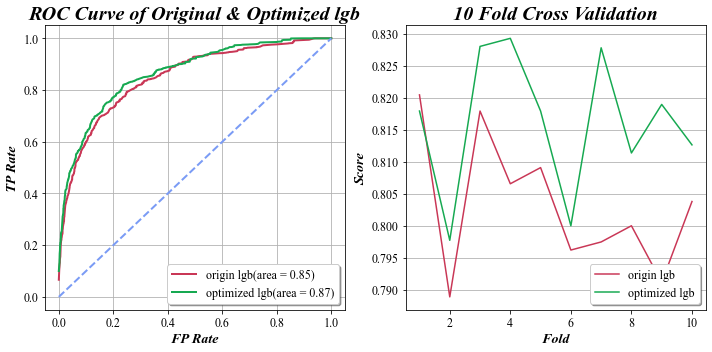

In [141]:
lgb_compare=[
    ('origin lgb',lgb.LGBMClassifier(random_state = seed,
                               learning_rate=0.5,
                               objective='multiclass',
                               boosting_type='gbdt',
                               num_class=3,
                               verbose=-1,
                               verbose_eval=False)),
    ('optimized lgb', lgb.LGBMClassifier(random_state = seed,
                                         learning_rate=0.05,
                                         n_estimators=500,
                                         early_stop_round=20,
                                         min_child_samples=23,
                                         num_leaves=7,
                                         max_depth=3,
                                         num_class=3,
                                         objective='multiclass',
                                         subsample=0.8,
                                         verbose=-1,
                                         verbose_eval=False,))
]

compare_plot(lgb_compare)

<h3>3.2.2. AdaBoost</h3>

In [90]:
param_grid=[{
    'n_estimators':[5,10,20,30,50],
    'learning_rate':[0.01,0.03,0.05,0.1,0.3],
    'random_state':[seed]

}]
grid = GridSearchCV(estimator=AdaBoostClassifier(),
                    param_grid=param_grid,
                    cv=10,
                    scoring='neg_log_loss').fit(X_train,y_train)

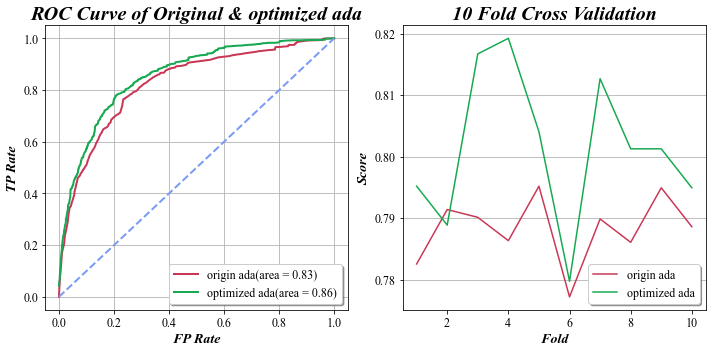

In [17]:
ada_compare=[
    ('origin ada',AdaBoostClassifier(random_state = seed,
                                     n_estimators=10)),
    ('optimized ada', AdaBoostClassifier(random_state = seed,
                                         learning_rate=0.3,
                                         n_estimators=50))
]
compare_plot(ada_compare)

<h3>3.2.3 逻辑回归</h3>

In [92]:
param_grid=[{
    'penalty':['l2'],
    'solver':['liblinear','lbfgs', 'sag','newton-cg', 'saga'],
    'random_state':[seed],
    'class_weight':['balanced']
}]
grid = GridSearchCV(estimator=LogisticRegression(),
                    param_grid=param_grid,
                    cv=10,
                    scoring='neg_log_loss').fit(X_train,y_train)

c:\Users\15835\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\15835\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

c:\Users\15835\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\15835\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

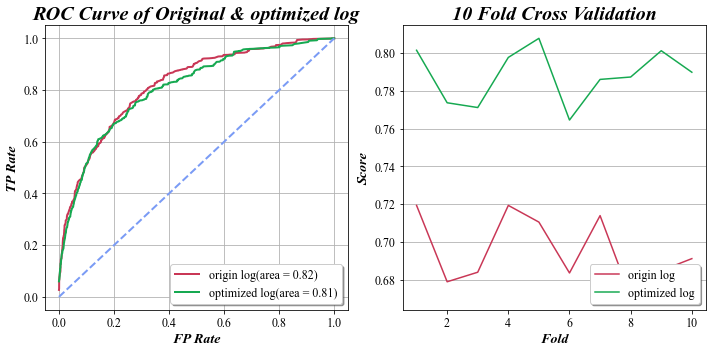

In [18]:
log_compare=[
    ('origin log',LogisticRegression(random_state = seed,
                                     class_weight='balanced')),
    ('optimized log', LogisticRegression(random_state = seed,
                                         class_weight='balanced',
                                         penalty='l2',
                                         solver='liblinear'))
]
compare_plot(log_compare)

<h3>3.2.4. 随机森林</h3>

In [123]:
param_grid=[{
    'objective':['multiclass'],
    'num_class':[3],
    'random_state':[seed],
    'min_child_samples':[20,22,25],
    'learning_rate':[0.05],
    'max_depth':[3,4,5],
    'subsample':[i/10 for i in range(8,11)],
    'n_estimators':[100],
    'boosting_type':['rf'],
    'verbose': [-1],
    'bagging_fraction':[0.4,0.3,0.5],
    'bagging_freq':[1]
}]
grid = GridSearchCV(estimator=lgb.LGBMClassifier(verbose_eval=False),
                    param_grid=param_grid,
                    cv=10,
                    scoring='neg_log_loss').fit(X_train,y_train)
grid.best_params_

{'bagging_fraction': 0.3,
 'bagging_freq': 1,
 'boosting_type': 'rf',
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 100,
 'num_class': 3,
 'objective': 'multiclass',
 'random_state': 42,
 'subsample': 0.8,
 'verbose': -1}

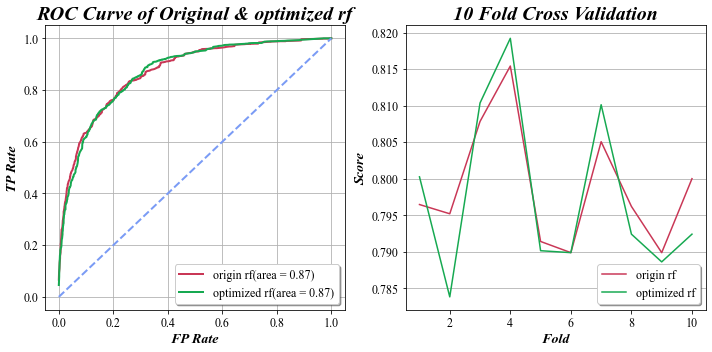

In [19]:
rf_compare=[
    ('origin rf',lgb.LGBMClassifier(random_state = seed,
                              objective='multiclass',
                              boosting_type='rf',
                              num_class=3,
                              bagging_fraction=0.7,
                              bagging_freq=1,
                              verbose=-1,
                              verbose_eval=False)),
    ('optimized rf', lgb.LGBMClassifier(random_state = seed,
                              objective='multiclass',
                              boosting_type='rf',
                              num_class=3,
                              n_estimators=100,
                              min_child_samples=20,
                              max_depth=5,
                              bagging_fraction=0.3,
                              bagging_freq=1,
                              verbose=-1,
                              verbose_eval=False))
]
compare_plot(rf_compare)

<h2>3.3. 神经网络</h2>

In [20]:
torch.cuda.empty_cache()
X = preprocessed_X
y = y
X_train,X_val,y_train_temp,y_val_temp = train_test_split(X,y,random_state=seed, shuffle=False)
y_train=[]
y_val=[]
for i in y_train_temp:
    temp=[0,0,0]
    temp[i]=1
    y_train.append(temp)
for i in y_val_temp:
    temp=[0,0,0]
    temp[i]=1
    y_val.append(temp)
X_train=torch.tensor(X_train, dtype=torch.float32).to('cuda:0')
X_val = torch.tensor(X_val,dtype=torch.float32).to('cuda:0')
y_val = torch.tensor(y_val,dtype=torch.float32).to('cuda:0')
y_train =torch.tensor(y_train,dtype=torch.float32).to('cuda:0')


<h3>3.3.1. 全前馈神经网络</h3>

In [21]:
device = torch.device('cuda:0')

class MulticlassNN(torch.nn.Module):
    def __init__ (self, in_channels,hidden_channels,out_channels):
        super(MulticlassNN,self).__init__()
        self.hidden1 = torch.nn.Linear(in_channels,hidden_channels)
        #self.hidden2 = torch.nn.Linear(hidden_channels,32)
        self.output = torch.nn.Linear(hidden_channels,out_channels)
    def forward(self,x):
        x=F.relu(self.hidden1(x))
        #x=F.relu(self.hidden2(x))
        x=self.output(x)
        return F.softmax(x,dim=1)
    
def test(model):
    model.eval()
    with torch.no_grad():
        out=model(X_val)
        model.train()
    out = out.cpu().numpy()
    val =y_val.cpu().numpy()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(np.array(val)[:, i],out[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(3):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 3
    return auc(all_fpr, mean_tpr), [all_fpr,mean_tpr]
    

def train_NN():
    model=MulticlassNN(len(preprocessed_X[0]),48,3).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    min_epochs = 10
    best_model = None
    best_val_auc = 0
    final_test_auc = 0
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        out=model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()

        test_auc, test_set = test(model)
        if epoch + 1 > min_epochs and test_auc > best_val_auc:
            best_val_auc = test_auc
            final_test_auc = test_set
        print('epoch {:03d} train_loss {:.8f} test_auc {:.4f}'
              .format(epoch, loss.item(),test_auc))

    return final_test_auc


In [22]:
NN_final_test_auc = train_NN()

epoch 000 train_loss 1.11851239 test_auc 0.5858
epoch 001 train_loss 1.11319077 test_auc 0.6011
epoch 002 train_loss 1.10789371 test_auc 0.6155
epoch 003 train_loss 1.10261798 test_auc 0.6285
epoch 004 train_loss 1.09736133 test_auc 0.6402
epoch 005 train_loss 1.09212363 test_auc 0.6510
epoch 006 train_loss 1.08690131 test_auc 0.6603
epoch 007 train_loss 1.08169413 test_auc 0.6685
epoch 008 train_loss 1.07649875 test_auc 0.6754
epoch 009 train_loss 1.07131147 test_auc 0.6818
epoch 010 train_loss 1.06612813 test_auc 0.6874
epoch 011 train_loss 1.06094480 test_auc 0.6923
epoch 012 train_loss 1.05575705 test_auc 0.6968
epoch 013 train_loss 1.05055928 test_auc 0.7006
epoch 014 train_loss 1.04534698 test_auc 0.7041
epoch 015 train_loss 1.04011559 test_auc 0.7072
epoch 016 train_loss 1.03486168 test_auc 0.7101
epoch 017 train_loss 1.02958262 test_auc 0.7126
epoch 018 train_loss 1.02427685 test_auc 0.7150
epoch 019 train_loss 1.01893747 test_auc 0.7172
epoch 020 train_loss 1.01355994 test_auc

<h3>3.3.2. 循环神经网络</h3>

In [24]:
num_time_steps = 16 # 训练时时间窗的步长
input_size = len(preprocessed_X[0]) # 输入数据维度
hidden_size = 32 # 隐含层维度
output_size = 3 # 输出维度
num_layers = 1
lr=0.01


class  MulticlassRNN(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size,num_layers) -> None:
        super(MulticlassRNN,self).__init__()
        self.rnn = torch.nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        for p in self.rnn.parameters():
          nn.init.normal_(p, mean=0.0, std=0.001)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self,x, hidden_prev):
       out, hidden_prev = self.rnn(x, hidden_prev)
       out = out.view(-1, hidden_size)
       out = self.linear(out)
       out = out.unsqueeze(dim=0)
       return out, hidden_prev


def RNN_test(model):
    model.eval()
    hidden_prev = torch.zeros(1,hidden_size).to(device)
    with torch.no_grad():
        out, hidden_prev=model(X_val,hidden_prev)
        model.train()
    out = F.softmax(out[0],dim=1).cpu().numpy()
    val =y_val.cpu().numpy()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(np.array(val)[:, i],out[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(3):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 3
    return auc(all_fpr, mean_tpr), [all_fpr,mean_tpr]

def tarin_RNN():
    best_val_auc=0
    final_test_auc=[]
    model = MulticlassRNN(input_size, hidden_size, num_layers=num_layers, output_size=3).to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    hidden_prev = torch.zeros(1,hidden_size).to(device)
    for epoch in range(100):
        optimizer.zero_grad()
        out, hidden_prev=model(X_train,hidden_prev)
        out = F.softmax(out[0],dim=1)
        hidden_prev = hidden_prev.detach()
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()

        test_auc, test_set = RNN_test(model)
        if epoch + 1 > 10 and test_auc > best_val_auc:
            best_val_auc = test_auc
            final_test_auc = test_set
        print('epoch {:03d} train_loss {:.8f} test_auc {:.4f}'
              .format(epoch, loss.item(),test_auc))
    
    return final_test_auc




In [25]:
RNN_final_test_auc=tarin_RNN()

epoch 000 train_loss 1.09500444 test_auc 0.7105
epoch 001 train_loss 1.08989716 test_auc 0.7068
epoch 002 train_loss 1.08460712 test_auc 0.7072
epoch 003 train_loss 1.07902789 test_auc 0.7087
epoch 004 train_loss 1.07312381 test_auc 0.7099
epoch 005 train_loss 1.06686449 test_auc 0.7121
epoch 006 train_loss 1.06021881 test_auc 0.7158
epoch 007 train_loss 1.05315447 test_auc 0.7207
epoch 008 train_loss 1.04563832 test_auc 0.7277
epoch 009 train_loss 1.03763783 test_auc 0.7338
epoch 010 train_loss 1.02912235 test_auc 0.7400
epoch 011 train_loss 1.02006650 test_auc 0.7458
epoch 012 train_loss 1.01045334 test_auc 0.7513
epoch 013 train_loss 1.00028121 test_auc 0.7551
epoch 014 train_loss 0.98957163 test_auc 0.7577
epoch 015 train_loss 0.97837937 test_auc 0.7586
epoch 016 train_loss 0.96680802 test_auc 0.7587
epoch 017 train_loss 0.95502561 test_auc 0.7576
epoch 018 train_loss 0.94327796 test_auc 0.7563
epoch 019 train_loss 0.93189561 test_auc 0.7550
epoch 020 train_loss 0.92128032 test_auc

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

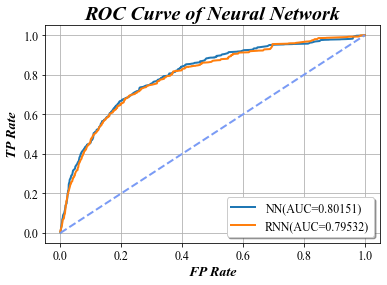

In [27]:
color_count=0
name_set=['NN','RNN']
for fpr_tpr_set in [NN_final_test_auc,RNN_final_test_auc]:
    fpr,tpr=fpr_tpr_set[0],fpr_tpr_set[1]
    AUC = auc(fpr,tpr)
    plt.plot(fpr,tpr, lw=2, label=name_set[color_count]+'(AUC={})'.format(round(AUC,5)))
    color_count+=1
plt.plot([0,1],[0,1], color='#7A9BF5', lw=2, linestyle='--')
plt.grid(linestyle='-',
         axis='both',)
plt.legend(loc='lower right',
            prop= {'family' : 'Times New Roman',
                      'weight' : 'normal',
                      'size'   : 12,},
            shadow=True,
            ncol = 1,
            fancybox= True)
plt.title('ROC Curve of Neural Network',
          fontdict=dict(fontsize=20,
                        color='black',
                        family='Times New Roman',
                        weight='bold',
                        style='italic',))
plt.xlabel('FP Rate',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.ylabel('TP Rate',
           fontdict=dict(fontsize=14,
                         color='black',
                         family='Times New Roman',
                         weight='bold',
                         style='italic',))
plt.xticks(fontproperties='Times New Roman', size = 12)
plt.yticks(fontproperties='Times New Roman', size = 12)
    
    
    